In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from GeoConformalizedExplainer import GeoConformalizedExplainer

C:\Users\Xiayin\miniconda3\envs\UncertaintyGeoXAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/china_sites_2018_05_PM2.5_all.csv')

In [3]:
data.head()

,id,name,city,lon,lat,date,PM2.5,row_index,col_index,proj_x,...,t2m,sp,tp,blh,e,r,u10,v10,aod_sat,ndvi
0,1001A,万寿西宫,北京,116.366,39.8673,20180531,60.548387,2201.0,6867.0,1.650848e+06,...,293.967224,100044.187500,0.000634,164.847870,-0.000010,44.939587,0.764578,1.060548,0.660040,3932
1,1002A,定陵,北京,116.170,40.2865,20180531,57.224138,2134.0,6835.0,1.625004e+06,...,291.590820,96484.054688,0.000450,101.149689,-0.000010,51.034016,0.007471,-0.032906,0.568065,7575
2,1003A,东四,北京,116.434,39.9522,20180531,67.258065,2188.0,6877.0,1.653777e+06,...,294.037201,100061.195312,0.000598,163.240631,-0.000009,44.052452,0.581442,1.025983,0.683423,3769
3,1004A,天坛,北京,116.434,39.8745,20180531,57.080645,2200.0,6877.0,1.655828e+06,...,294.102112,100167.195312,0.000655,175.418289,-0.000011,44.226921,0.670114,1.145302,0.653063,4337
4,1005A,农展馆,北京,116.473,39.9716,20180531,57.935484,2185.0,6884.0,1.656225e+06,...,294.140289,100108.039062,0.000601,169.096985,-0.000009,43.352154,0.494377,1.053341,0.653476,3757


In [4]:
pm25 = data['PM2.5']

In [5]:
features = data[['dem', 'sp', 'tp', 'blh', 'r', 'aod_sat', 'ndvi', 'proj_x', 'proj_y']]

In [6]:
loc = data[['lon', 'lat']]

In [7]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, pm25, loc, train_size=0.8, random_state=42)

In [8]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [9]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8)

In [10]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
model.score(X_test, y_test)

0.7484278069641244

In [12]:
feature_names = X_train.columns

In [14]:
explainer = GeoConformalizedExplainer(prediction_f=model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      coord_test=loc_test.values,
                                      miscoverage_level=0.1,
                                      band_width=5,
                                      feature_names=feature_names)

In [15]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

Training SHAP


100%|██████████| 1132/1132 [10:39<00:00,  1.77it/s]


Calibrating SHAP


100%|██████████| 141/141 [01:08<00:00,  2.05it/s]


Testing SHAP


100%|██████████| 142/142 [01:08<00:00,  2.07it/s]


Explaining Variables


In [16]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
dem,0.943662,0.864492,0.715527,3.778215,4.026080
sp,0.887324,0.802516,0.788997,3.152240,2.637241
tp,0.887324,0.316745,0.897184,1.178095,0.718018
blh,0.866197,0.400249,1.277104,2.719456,4.271343
r,0.866197,0.944498,0.995546,17.857171,18.945977
aod_sat,0.866197,0.948297,1.260240,30.718122,34.468625
ndvi,0.957746,0.319043,1.065275,1.666493,1.420970
proj_x,0.901408,0.876941,1.084412,9.555981,9.022946
proj_y,0.873239,0.937648,1.198986,23.055573,24.006518


In [17]:
results.accuracy_summary().to_csv('./ChinaPM25accuracy_summary.csv')

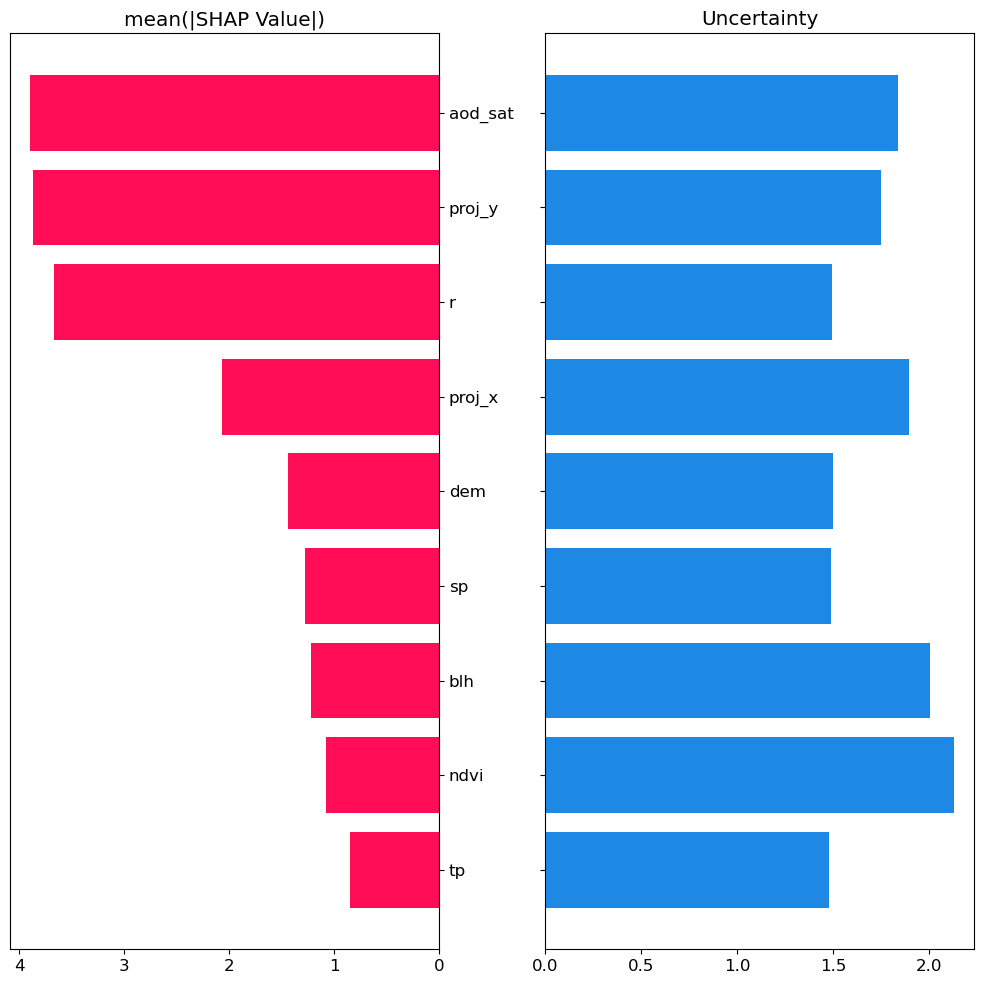

In [18]:
results.plot_absolute_shap_value_with_uncertainty(filename='./ChinaPM25absolute_shap_value_with_uncertainty.pdf')

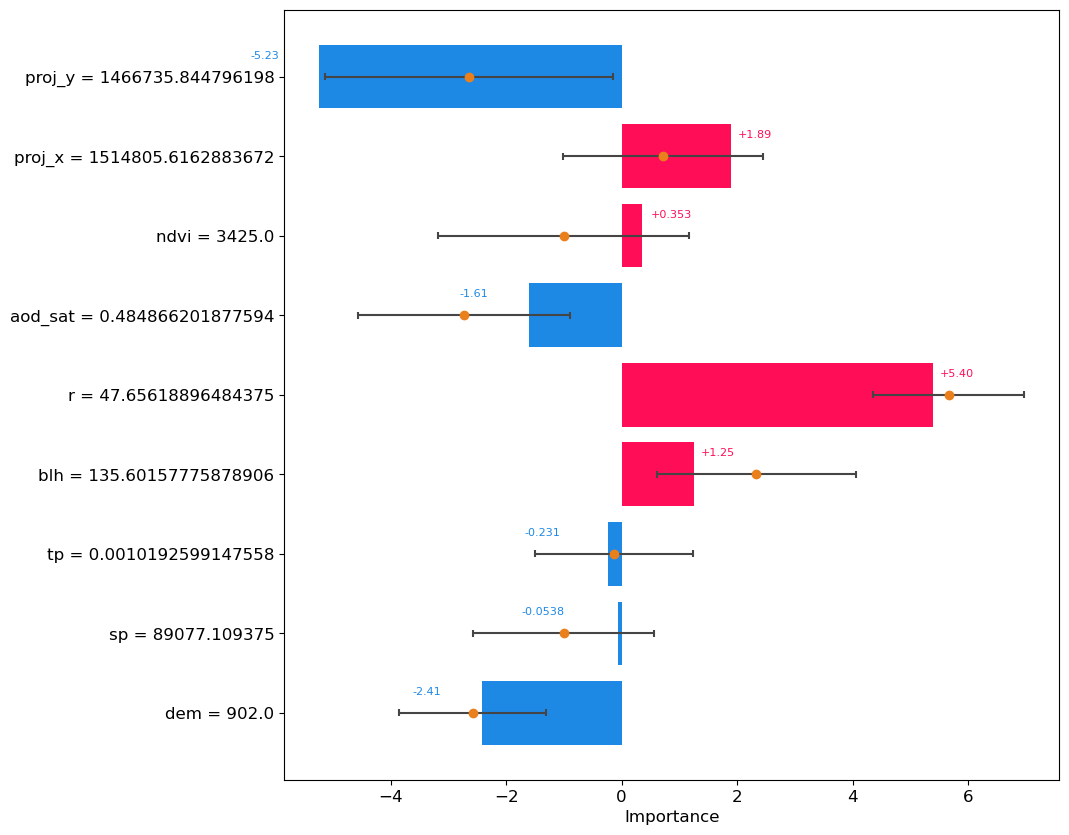

In [19]:
 results.plot_shap_values_with_uncertainty(10, filename='./ChinaPM25shap_values_with_uncertainty.pdf')

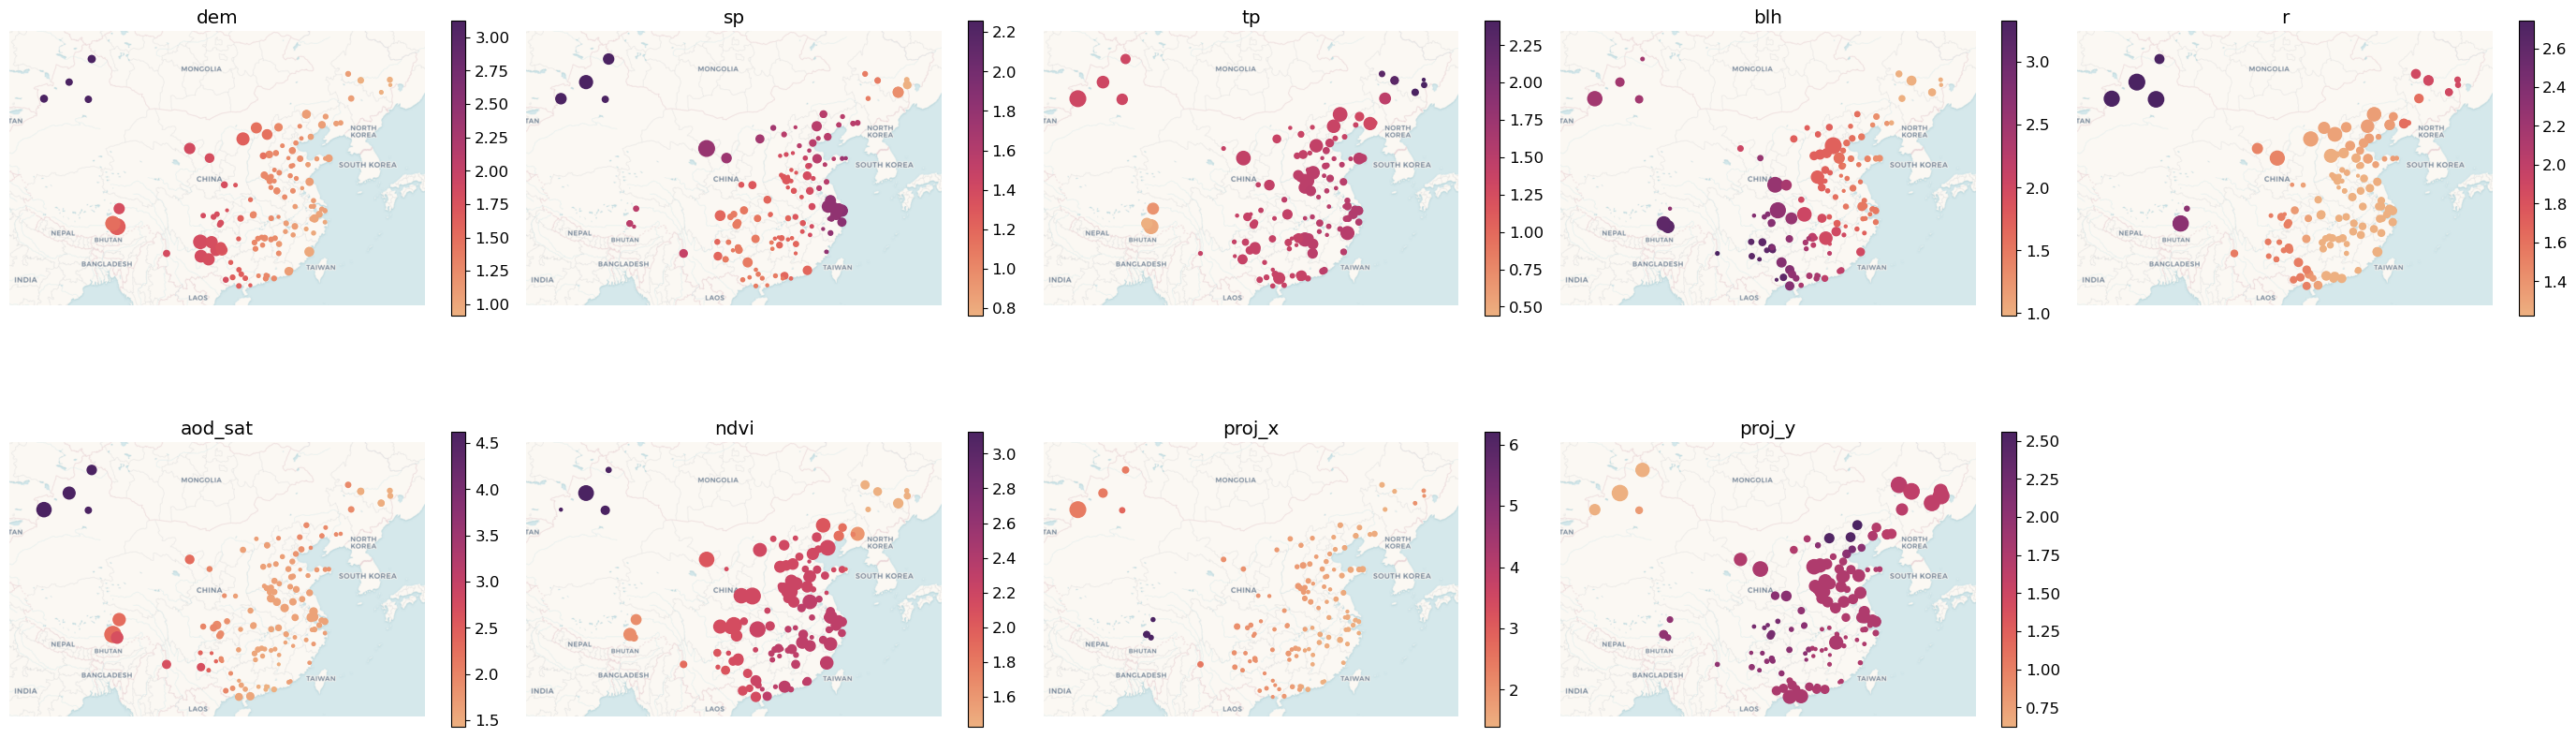

In [20]:
results.plot_geo_uncertainty(figsize=(28, 10), shrink=0.6, filename='./ChinaPM25geo_uncertainty.pdf')

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

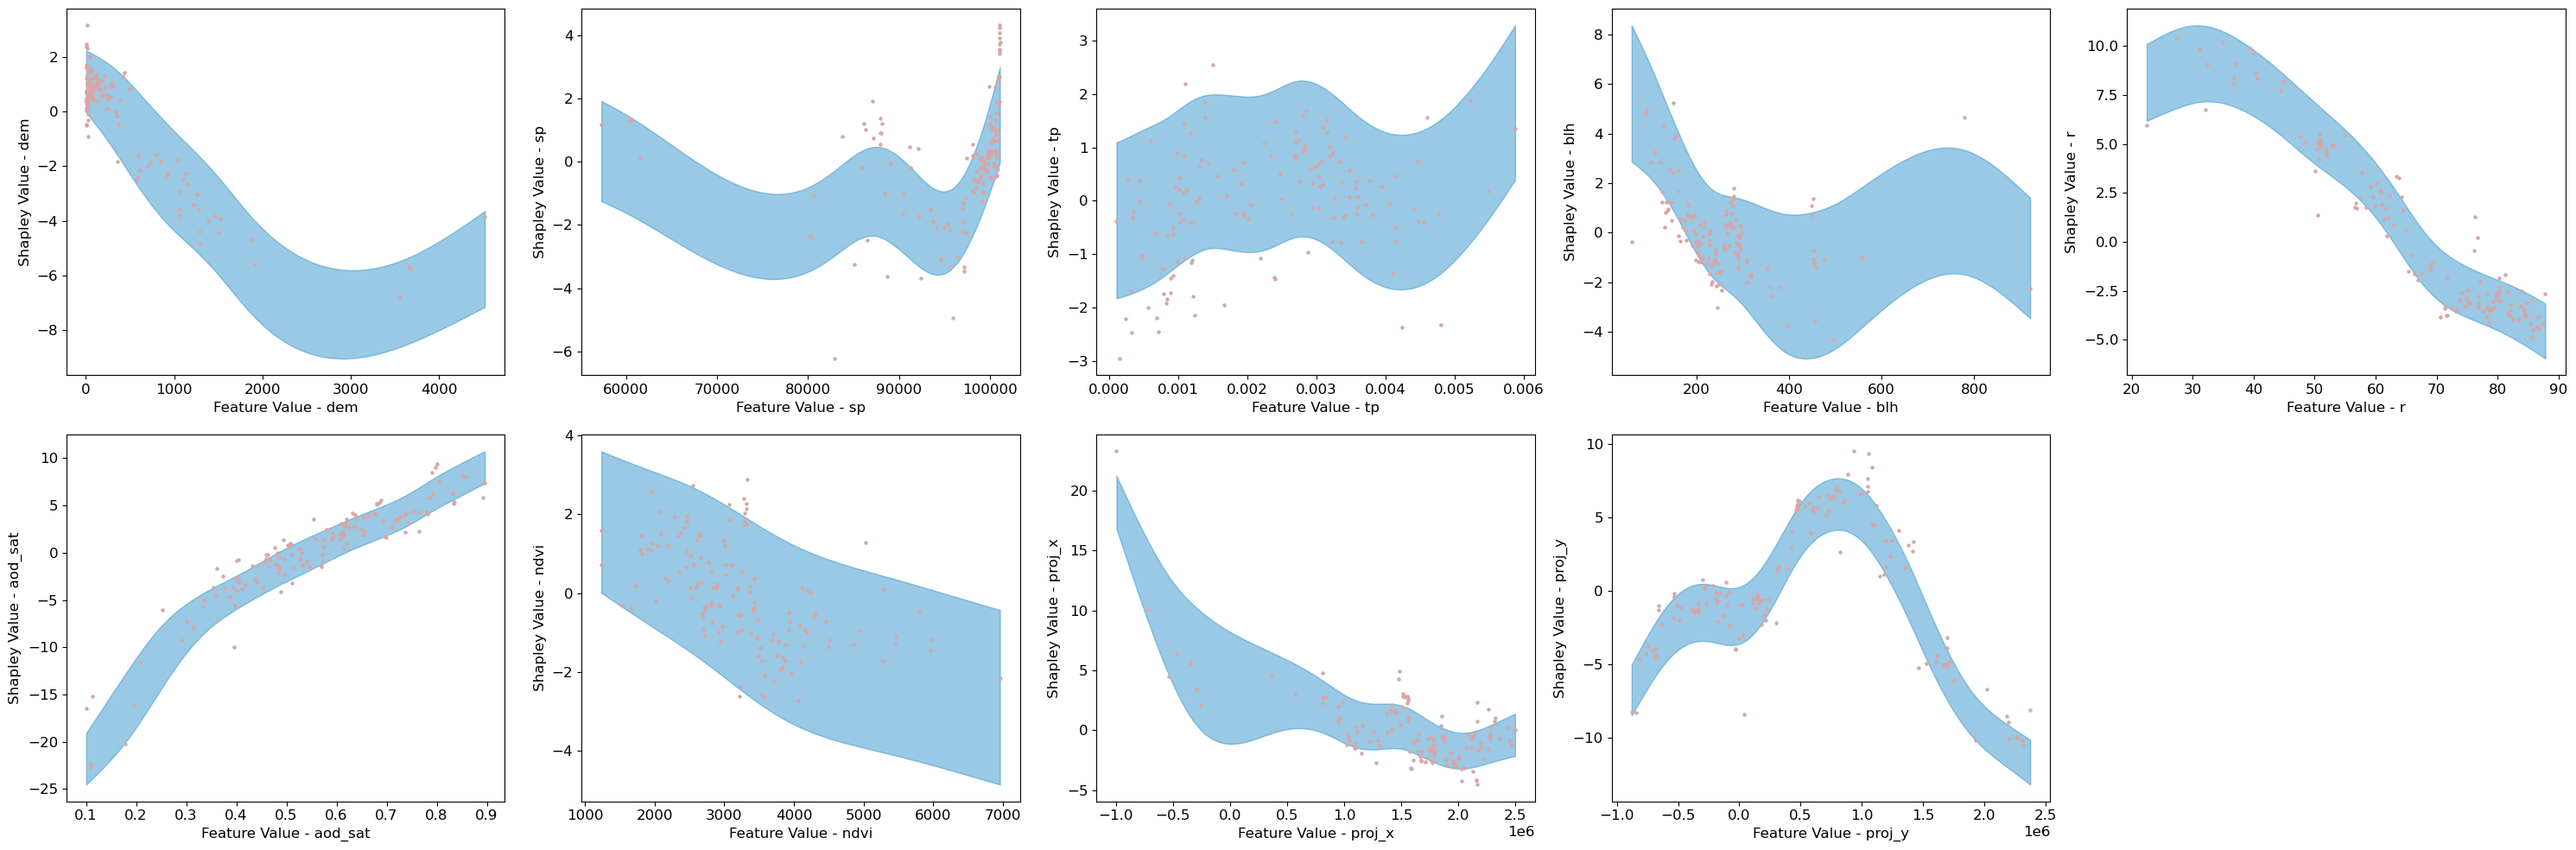

In [21]:
results.plot_partial_dependence_with_fitted_bounds(filename='./ChinaPM25partial_dependence_with_fitted_bounds.pdf')